## Spooky Author Identification

### Import necessary libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read 'spooky.csv' dataset

In [2]:
df=pd.read_csv('spooky.csv')

In [3]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### Drop 'id' column

In [4]:
df.drop(columns='id')

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
19574,"I could have fancied, while I looked at it, th...",EAP
19575,The lids clenched themselves together as if in...,EAP
19576,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,"For an item of news like this, it strikes us i...",EAP


In [7]:
df

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
19574,"I could have fancied, while I looked at it, th...",EAP
19575,The lids clenched themselves together as if in...,EAP
19576,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,"For an item of news like this, it strikes us i...",EAP


### Check for missing values

In [5]:
df.isna().sum()

id        0
text      0
author    0
dtype: int64

### Check for duplicates

In [6]:
df.duplicated().sum()

0

### Print some of the text along with its author

In [7]:
for i in range(5):
    print(df['text'][i],'-',df['author'][i])
    print()

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. - EAP

It never once occurred to me that the fumbling might be a mere mistake. - HPL

In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction. - EAP

How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair. - MWS

Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk. - HPL



### Create a function to preproces the text

In [8]:
import re
from nltk.stem import WordNetLemmatizer

In [9]:
def preprocess(sentence):
    sentence=sentence.lower()
    text= re.sub(r"[^0-9a-zA-Z]",' ',sentence).split()
    
    lemma=WordNetLemmatizer()
    word=[lemma.lemmatize(word,'v') for word in text]
    
    return ' '.join(word)

In [10]:
df['text']=df['text'].apply(preprocess)

### Print some of the text after preprocess

In [11]:
for i in range(5):
    print(df['text'][i],'-',df['author'][i])
    print()

this process however afford me no mean of ascertain the dimension of my dungeon as i might make its circuit and return to the point whence i set out without be aware of the fact so perfectly uniform seem the wall - EAP

it never once occur to me that the fumble might be a mere mistake - HPL

in his leave hand be a gold snuff box from which as he caper down the hill cut all manner of fantastic step he take snuff incessantly with an air of the greatest possible self satisfaction - EAP

how lovely be spring as we look from windsor terrace on the sixteen fertile counties spread beneath speckle by happy cottages and wealthier towns all look as in former years heart cheer and fair - MWS

find nothing else not even gold the superintendent abandon his attempt but a perplex look occasionally steal over his countenance as he sit think at his desk - HPL



### Check for imbalance in the dataset

<Axes: ylabel='count'>

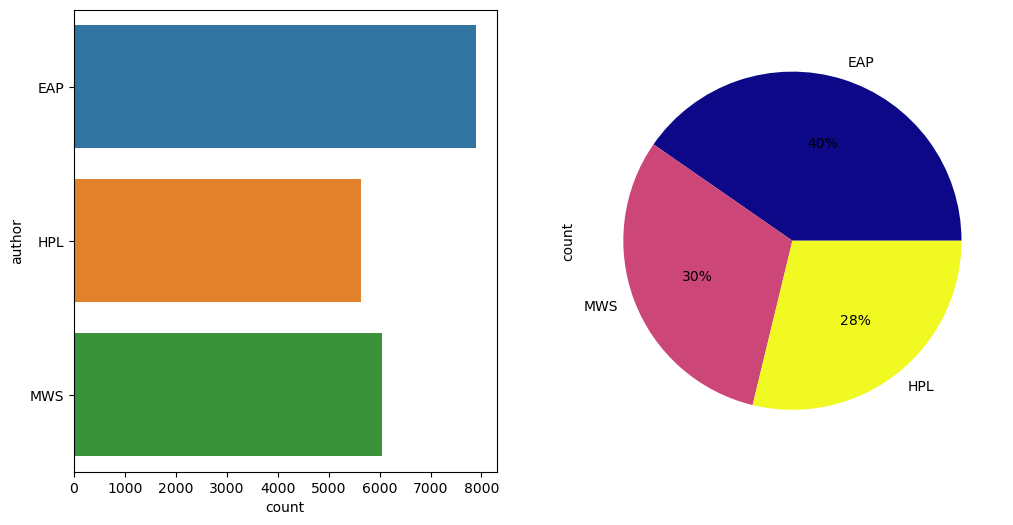

In [12]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(y=df['author'])

plt.subplot(1,2,2)
df['author'].value_counts().plot.pie(autopct='%1.i%%',cmap='plasma')

### Split the dataset into Input & Target Variables

In [13]:
X=df['text']
y=df['author']

### Label Encode our target variables

In [14]:
from sklearn.preprocessing import LabelBinarizer

In [15]:
encoder=LabelBinarizer()

In [16]:
y=encoder.fit_transform(y)

In [17]:
y

array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

### Create Keras tokenizer object with 5000 max words
* Convert text to sequence
* Add padding

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [19]:
tokenizer=Tokenizer(num_words=5000)

In [20]:
tokenizer.fit_on_texts(X)

In [21]:
vocab_size=len(tokenizer.word_index)+1

In [22]:
vocab_size

19602

In [39]:
def text_encoding(txt):
    encoded_docs=tokenizer.texts_to_sequences(txt)
    
    padded_sequence=pad_sequences(encoded_docs,maxlen=128)
    return padded_sequence

In [40]:
X=text_encoding(X)

### Split the dataset into Training & Testing set

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

### Create keras Sequential model with GRU layers

In [43]:
from tensorflow.keras import Sequential,layers

In [44]:
model=Sequential()

In [45]:
model.add(layers.Embedding(vocab_size,128))
model.add(layers.GRU(128,return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.GRU(128))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(3,activation='softmax'))

### Compile the model

In [53]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

### Train the model

In [54]:
model.fit(X_train,y_train,epochs=10,validation_split=0.05)

Epoch 1/10
465/465 [==============================] - 69s 142ms/step - loss: 0.6919 - accuracy: 0.6972 - val_loss: 0.5332 - val_accuracy: 0.7870
Epoch 2/10
465/465 [==============================] - 64s 137ms/step - loss: 0.3744 - accuracy: 0.8572 - val_loss: 0.5097 - val_accuracy: 0.8151
Epoch 3/10
465/465 [==============================] - 63s 135ms/step - loss: 0.2786 - accuracy: 0.8956 - val_loss: 0.5447 - val_accuracy: 0.7883
Epoch 4/10
465/465 [==============================] - 63s 135ms/step - loss: 0.2040 - accuracy: 0.9266 - val_loss: 0.5821 - val_accuracy: 0.8048
Epoch 5/10
465/465 [==============================] - 61s 132ms/step - loss: 0.1507 - accuracy: 0.9441 - val_loss: 0.7773 - val_accuracy: 0.7819
Epoch 6/10
465/465 [==============================] - 62s 132ms/step - loss: 0.1165 - accuracy: 0.9614 - val_loss: 0.7597 - val_accuracy: 0.7806
Epoch 7/10
465/465 [==============================] - 62s 133ms/step - loss: 0.1012 - accuracy: 0.9618 - val_loss: 0.8351 - val_ac

### Make predictions with X_test

In [55]:
y_pred=modelel.predict(X_test)

123/123 [==============================] - 5s 35ms/step


### Fetch the index of the higher probable prediction

In [59]:
y_pred=[np.argmax(i) for i in y_pred]
y_test=[np.argmax(i) for i in y_test]

### Evaluate the model

#### Accuracy score

In [60]:
from sklearn import metrics

In [61]:
metrics.accuracy_score(y_test,y_pred)

0.3991317671092952

#### Confusion matrix

<Axes: >

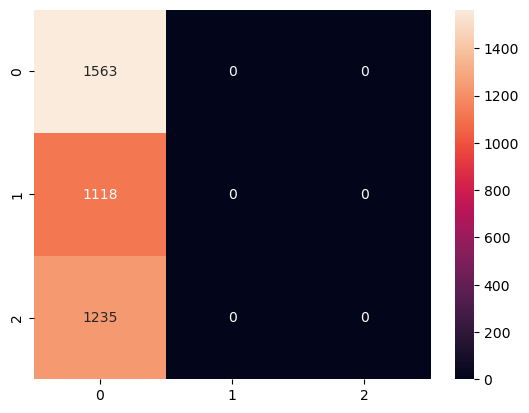

In [63]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='d')

#### Classification Report

In [64]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57      1563
           1       0.00      0.00      0.00      1118
           2       0.00      0.00      0.00      1235

    accuracy                           0.40      3916
   macro avg       0.13      0.33      0.19      3916
weighted avg       0.16      0.40      0.23      3916



C:\Users\aryav\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aryav\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aryav\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
